![](img/330-banner.png)

# Lecture 12: Feature importances and model transparency

UBC 2023-24

Instructor: Varada Kolhatkar

## Imports, announcements, LOs

### Imports

In [1]:
import os
import string
import sys
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append(os.path.join(os.path.abspath("."), "code"))
import seaborn as sns
from plotting_functions import *
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from utils import *

%matplotlib inline

### Learning outcomes 

From this lecture, students are expected to be able to:

- Interpret the coefficients of linear regression for ordinal, one-hot encoded categorical, and scaled numeric features. 
- Explain why interpretability is important in ML.
- Use `feature_importances_` attribute of `sklearn` models and interpret its output. 
- Apply SHAP to assess feature importances and interpret model predictions. 
- Explain force plot, summary plot, and dependence plot produced with shapely values.  

In [2]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

### Announcement

- Midterm is next week.  
    - Bring your laptop. Make sure that it's fully charged. 
    - Bring your UBC ID Card. 
- HW5 is available.     
- My OH on Thursday has been cancelled. I'll hold OH on Tuesday instead.   

<br><br>

I'm using `seaborn` in this lecture for easy heatmap plotting, which is not in the course environment. You can install it as follows. 
```
> conda activate cpsc330
> conda install -c anaconda seaborn
```

In [3]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

## Data 

In the first part of this lecture, we'll be using [Kaggle House Prices dataset](https://www.kaggle.com/c/home-data-for-ml-course/), the dataset we used in lecture 10. As usual, to run this notebook you'll need to download the data. Unzip the data into a subdirectory called `data`. For this dataset, train and test have already been separated. We'll be working with the train portion in this lecture. 

In [4]:
df = pd.read_csv("data/housing-kaggle/train.csv")
train_df, test_df = train_test_split(df, test_size=0.10, random_state=123)
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
302,303,20,RL,118.0,13704,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2006,WD,Normal,205000
767,768,50,RL,75.0,12508,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,1300,7,2008,WD,Normal,160000
429,430,20,RL,130.0,11457,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Normal,175000
1139,1140,30,RL,98.0,8731,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,144000
558,559,60,RL,57.0,21872,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,8,2008,WD,Normal,175000


- The prediction task is predicting `SalePrice` given features related to properties.  
- Note that the target is numeric, not categorical.

In [5]:
train_df.shape

(1314, 81)

### Let's separate `X` and `y`

In [6]:
X_train = train_df.drop(columns=["SalePrice"])
y_train = train_df["SalePrice"]

X_test = test_df.drop(columns=["SalePrice"])
y_test = test_df["SalePrice"]

### Let's identify feature types

In [7]:
drop_features = ["Id"]
numeric_features = [
    "BedroomAbvGr",
    "KitchenAbvGr",
    "LotFrontage",
    "LotArea",
    "OverallQual",
    "OverallCond",
    "YearBuilt",
    "YearRemodAdd",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageYrBlt",
    "GarageCars",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "YrSold",
]

In [8]:
ordinal_features_reg = [
    "ExterQual",
    "ExterCond",
    "BsmtQual",
    "BsmtCond",
    "HeatingQC",
    "KitchenQual",
    "FireplaceQu",
    "GarageQual",
    "GarageCond",
    "PoolQC",
]
ordering = [
    "Po",
    "Fa",
    "TA",
    "Gd",
    "Ex",
]  # if N/A it will just impute something, per below
ordering_ordinal_reg = [ordering] * len(ordinal_features_reg)
ordering_ordinal_reg

[['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex']]

In [9]:
ordinal_features_oth = [
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "Functional",
    "Fence",
]
ordering_ordinal_oth = [
    ["NA", "No", "Mn", "Av", "Gd"],
    ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    ["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"],
    ["NA", "MnWw", "GdWo", "MnPrv", "GdPrv"],
]

In [10]:
categorical_features = list(
    set(X_train.columns)
    - set(numeric_features)
    - set(ordinal_features_reg)
    - set(ordinal_features_oth)
    - set(drop_features)
)
categorical_features

['PavedDrive',
 'RoofStyle',
 'Foundation',
 'RoofMatl',
 'SaleCondition',
 'MiscFeature',
 'CentralAir',
 'Alley',
 'BldgType',
 'Condition2',
 'Exterior1st',
 'Exterior2nd',
 'LotConfig',
 'HouseStyle',
 'GarageType',
 'SaleType',
 'Neighborhood',
 'Street',
 'Condition1',
 'MasVnrType',
 'LandContour',
 'GarageFinish',
 'MoSold',
 'Utilities',
 'Heating',
 'Electrical',
 'MSSubClass',
 'LandSlope',
 'MSZoning',
 'LotShape']

In [11]:
from sklearn.compose import ColumnTransformer, make_column_transformer

numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
ordinal_transformer_reg = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=ordering_ordinal_reg),
)

ordinal_transformer_oth = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=ordering_ordinal_oth),
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

preprocessor = make_column_transformer(
    ("drop", drop_features),
    (numeric_transformer, numeric_features),
    (ordinal_transformer_reg, ordinal_features_reg),
    (ordinal_transformer_oth, ordinal_features_oth),
    (categorical_transformer, categorical_features),
)

In [12]:
preprocessor.fit(X_train)
preprocessor.named_transformers_

{'drop': 'drop',
 'pipeline-1': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 'pipeline-2': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                      

In [13]:
ohe_columns = list(
    preprocessor.named_transformers_["pipeline-4"]
    .named_steps["onehotencoder"]
    .get_feature_names_out(categorical_features)
)
new_columns = (
    numeric_features + ordinal_features_reg + ordinal_features_oth + ohe_columns
)

In [14]:
X_train_enc = pd.DataFrame(
    preprocessor.transform(X_train), index=X_train.index, columns=new_columns
)
X_train_enc

,BedroomAbvGr,KitchenAbvGr,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,LandSlope_Sev,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg
302,0.154795,-0.222647,2.312501,0.381428,0.663680,-0.512408,0.993969,0.840492,0.269972,-0.961498,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
767,1.372763,-0.222647,0.260890,0.248457,-0.054669,1.285467,-1.026793,0.016525,-0.573129,0.476092,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
429,0.154795,-0.222647,2.885044,0.131607,-0.054669,-0.512408,0.563314,0.161931,-0.573129,1.227559,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1139,0.154795,-0.222647,1.358264,-0.171468,-0.773017,-0.512408,-1.689338,-1.679877,-0.573129,0.443419,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
558,0.154795,-0.222647,-0.597924,1.289541,0.663680,-0.512408,0.828332,0.598149,-0.573129,0.354114,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,1.372763,-0.222647,-0.025381,-0.127107,-0.054669,2.184405,-0.165485,0.743555,0.843281,-0.090231,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1122,0.154795,-0.222647,-0.025381,-0.149788,-1.491366,-2.310284,-0.496757,-1.389065,-0.573129,-0.961498,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1346,0.154795,-0.222647,-0.025381,1.168244,0.663680,1.285467,-0.099230,0.888961,-0.573129,-0.314582,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1406,-1.063173,-0.222647,0.022331,-0.203265,-0.773017,1.285467,0.033279,1.082835,-0.573129,0.467379,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [15]:
X_train_enc.shape

(1314, 262)

In [16]:
lr_pipe = make_pipeline(preprocessor, Ridge())
scores = cross_validate(lr_pipe, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.032616,0.008111,0.835749,0.916722
1,0.026517,0.007387,0.810073,0.919198
2,0.023797,0.007133,0.831611,0.912395
3,0.024727,0.008341,0.843992,0.914003
4,0.024118,0.007278,0.548831,0.920462


<br><br><br><br>

## Feature importances

- How does the output depend upon the input? 
- How do the predictions change as a function of a particular feature?
- If the model is bad interpretability does not make sense. 

### SimpleFeature correlations

- Let's look at the correlations between various features with other features and the target in our encoded data (first row/column). 
- In simple terms here is how you can interpret correlations between two variables $X$ and $Y$:
  - If $Y$ goes up when $X$ goes up, we say $X$ and $Y$ are positively correlated.
  - If $Y$ goes down when $X$ goes up, we say $X$ and $Y$ are negatively correlated.
  - If $Y$ is unchanged when $X$ changes, we say $X$ and $Y$ are uncorrelated.

Let's examine the correlations among different columns, including the target column. 

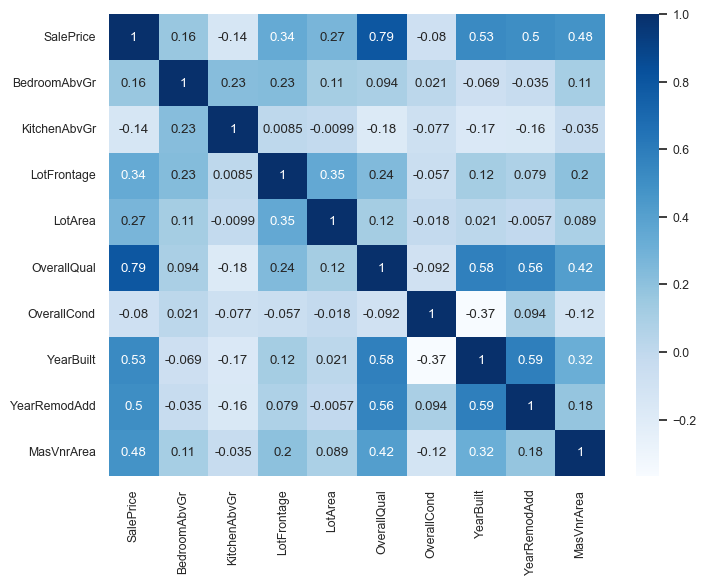

In [17]:
cor = pd.concat((y_train, X_train_enc), axis=1).iloc[:, :10].corr()
plt.figure(figsize=(8, 6))
sns.set(font_scale=0.8)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

- We can immediately see that `SalePrice` is highly correlated with `OverallQual`.
- This is an early hint that `OverallQual` is a useful feature in predicting `SalePrice`.
- However, this approach is **extremely simplistic**.
  - It only looks at each feature in isolation.
  - It only looks at linear associations:
    - What if `SalePrice` is high when `BsmtFullBath` is 2 or 3, but low when it's 0, 1, or 4? They might seem uncorrelated.

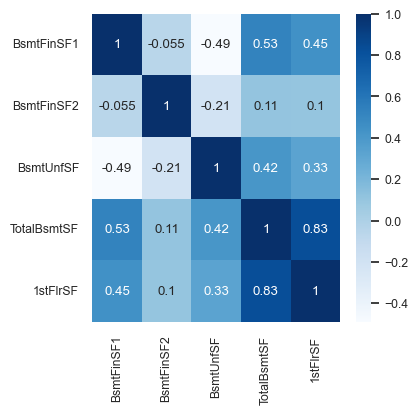

In [18]:
cor = pd.concat((y_train, X_train_enc), axis=1).iloc[:, 10:15].corr()
plt.figure(figsize=(4, 4))
sns.set(font_scale=0.8)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

- Looking at this diagram also tells us the relationship between features. 
  - For example, `1stFlrSF` and `TotalBsmtSF` are highly correlated. 
  - Do we need both of them?
  - If our model says `1stFlrSF` is very important and `TotalBsmtSF` is very unimportant, do we trust those values?
  - Maybe `TotalBsmtSF` only "becomes important" if `1stFlrSF` is removed.
  - Sometimes the opposite happens: a feature only becomes important if another feature is _added_.

<br><br>

### Feature importances in linear models 

- With linear regression we can look at the _coefficients_ for each feature.
- Overall idea: predicted price = intercept + $\sum_i$ coefficient i $\times$ feature i.

In [19]:
lr = make_pipeline(preprocessor, Ridge())
lr.fit(X_train, y_train);

Let's look at the coefficients. 

In [20]:
lr_coefs = pd.DataFrame(
    data=lr.named_steps["ridge"].coef_, index=new_columns, columns=["Coefficient"]
)
lr_coefs.head(20)

,Coefficient
BedroomAbvGr,-3717.542624
KitchenAbvGr,-4552.332671
LotFrontage,-1582.710031
LotArea,5118.035161
OverallQual,12498.401830
OverallCond,4854.438906
YearBuilt,4234.888066
YearRemodAdd,317.185155
MasVnrArea,5253.253432
BsmtFinSF1,3681.749118


Let's try to interpret coefficients for different types of features. 

### Ordinal features

- The ordinal features are easiest to interpret. 

In [21]:
print(ordinal_features_reg)

['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']


In [22]:
lr_coefs.loc["ExterQual"]

Coefficient    4236.969653
Name: ExterQual, dtype: float64

- Increasing by one category of exterior quality (e.g. good -> excellent) increases the predicted price by $\sim\$4195$.
  - Wow, that's a lot! 
  - Remember this is just what the model has learned. It doesn't tell us how the world works. 

In [23]:
one_example = X_test[:1]

In [24]:
one_example[["ExterQual"]]

,ExterQual
147,Gd


Let's perturb the example and change `ExterQual` to `Ex`. 

In [25]:
one_example_perturbed = one_example.copy()
one_example_perturbed["ExterQual"] = "Ex"  # Change Gd to Ex

In [26]:
one_example_perturbed[["ExterQual"]]

,ExterQual
147,Ex


How does the prediction change after changing `ExterQual` from `Gd` to `Ex`? 

In [27]:
print("Prediction on the original example: ", lr.predict(one_example))
print("Prediction on the perturbed example: ", lr.predict(one_example_perturbed))
print(
    "After changing ExterQual from Gd to Ex increased the prediction by: ",
    lr.predict(one_example_perturbed) - lr.predict(one_example),
)

Prediction on the original example:  [224865.34161762]
Prediction on the perturbed example:  [229102.31127015]
After changing ExterQual from Gd to Ex increased the prediction by:  [4236.96965253]


That's exactly the learned coefficient for `ExterQual`! 

In [28]:
lr_coefs.loc["ExterQual"]

Coefficient    4236.969653
Name: ExterQual, dtype: float64

So our interpretation is correct! 
- Increasing by one category of exterior quality (e.g. good -> excellent) increases the predicted price by $\sim\$4195$.

<br><br>

### Categorical features

- What about the categorical features?
- We have created a number of columns for each category with OHE and each category gets it's own coefficient. 

In [29]:
print(categorical_features)

['PavedDrive', 'RoofStyle', 'Foundation', 'RoofMatl', 'SaleCondition', 'MiscFeature', 'CentralAir', 'Alley', 'BldgType', 'Condition2', 'Exterior1st', 'Exterior2nd', 'LotConfig', 'HouseStyle', 'GarageType', 'SaleType', 'Neighborhood', 'Street', 'Condition1', 'MasVnrType', 'LandContour', 'GarageFinish', 'MoSold', 'Utilities', 'Heating', 'Electrical', 'MSSubClass', 'LandSlope', 'MSZoning', 'LotShape']


In [30]:
lr_coefs_landslope = lr_coefs[lr_coefs.index.str.startswith("LandSlope")]
lr_coefs_landslope

,Coefficient
LandSlope_Gtl,468.638169
LandSlope_Mod,7418.923432
LandSlope_Sev,-7887.561602


- We can talk about switching from one of these categories to another by picking a "reference" category:

In [31]:
lr_coefs_landslope - lr_coefs_landslope.loc["LandSlope_Gtl"]

,Coefficient
LandSlope_Gtl,0.000000
LandSlope_Mod,6950.285263
LandSlope_Sev,-8356.199771


- If you change the category from `LandSlope_Gtl` to `LandSlope_Mod` the prediction price goes up by $\sim\$6963$
- If you change the category from `LandSlope_Gtl` to `LandSlope_Sev` the prediction price goes down by $\sim\$8334$


Note that this might not make sense in the real world but this is what our model decided to learn given this small amount of data. 

In [32]:
one_example = X_test[:1]
one_example[['LandSlope']]

,LandSlope
147,Gtl


Let's perturb the example and change `LandSlope` to `Mod`. 

In [33]:
one_example_perturbed = one_example.copy()
one_example_perturbed["LandSlope"] = "Mod"  # Change Gd to Ex

In [34]:
one_example_perturbed[["LandSlope"]]

,LandSlope
147,Mod


How does the prediction change after changing `LandSlope` from `Gtl` to `Mod`? 

In [35]:
print("Prediction on the original example: ", lr.predict(one_example))
print("Prediction on the perturbed example: ", lr.predict(one_example_perturbed))
print(
    "After changing ExterQual from Gd to Ex increased the prediction by: ",
    lr.predict(one_example_perturbed) - lr.predict(one_example),
)

Prediction on the original example:  [224865.34161762]
Prediction on the perturbed example:  [231815.62688064]
After changing ExterQual from Gd to Ex increased the prediction by:  [6950.28526302]


Our interpretation above is correct! 

In [36]:
lr_coefs.sort_values(by="Coefficient")

,Coefficient
RoofMatl_ClyTile,-191169.071745
Condition2_PosN,-105656.864205
Heating_OthW,-27263.223804
MSZoning_C (all),-22001.877390
Exterior1st_ImStucc,-19422.775311
...,...
PoolQC,34182.041704
RoofMatl_CompShg,36525.193346
Neighborhood_NridgHt,37546.996765
Neighborhood_StoneBr,39931.371722


- For example, the above coefficient says that "If the roof is made of clay or tile, the predicted price is \\$191K less"?
- Do we believe these interpretations??
  - Do we believe this is how the predictions are being computed? Yes.
  - Do we believe that this is how the world works? No. 

```{note}
If you did `drop='first'` (we didn't) then you already have a reference class, and all the values are with respect to that one. The interpretation depends on whether we did `drop='first'`, hence the hassle.
```

<br><br>

### Interpreting coefficients of numeric features

Let's look at coefficients of `PoolArea`, `LotFrontage`, `LotArea`. 

In [37]:
lr_coefs.loc[["PoolArea", "LotFrontage", "LotArea"]]

,Coefficient
PoolArea,2817.196385
LotFrontage,-1582.710031
LotArea,5118.035161


Intuition: 

- Tricky because numeric features are **scaled**! 
- **Increasing** `PoolArea` by 1 scaled unit **increases** the predicted price by $\sim\$2822$.
- **Increasing** `LotArea` by 1 scaled unit **increases** the predicted price by $\sim\$5109$.
- **Increasing** `LotFrontage` by 1 scaled unit **decreases** the predicted price by $\sim\$1578$.

Does that sound reasonable?

- For `PoolArea` and `LotArea`, yes. 
- For `LotFrontage`, that's surprising. Something positive would have made more sense?

It might be the case that `LotFrontage` is correlated with some other variable, which might have a larger positive coefficient. 

BTW, let's make sure the predictions behave as expected:

#### Example showing how can we interpret coefficients of scaled features. 

- What's one scaled unit for `LotArea`? 
- The scaler subtracted the mean and divided by the standard deviation.
- The division actually changed the scale! 
- For the unit conversion, we don't care about the subtraction, but only the scaling.

In [38]:
scaler = preprocessor.named_transformers_["pipeline-1"]["standardscaler"]

In [39]:
lr_scales = pd.DataFrame(
    data=np.sqrt(scaler.var_), index=numeric_features, columns=["Scale"]
)
lr_scales.head()

,Scale
BedroomAbvGr,0.821040
KitchenAbvGr,0.218760
LotFrontage,20.959139
LotArea,8994.471032
OverallQual,1.392082


- It seems like `LotArea` was divided by 8994.471032 sqft. 

In [40]:
lr_coefs.loc[["LotArea"]]

,Coefficient
LotArea,5118.035161


- The coefficient tells us that if we increase the **scaled** `LotArea` by one scaled unit the price would go up by $\approx\$5118$. 
- One scaled unit represents $\sim 8994$ sqft in the original scale. 

Let's examine whether this behaves as expected. 

In [41]:
X_test_enc = pd.DataFrame(
    preprocessor.transform(X_test), index=X_test.index, columns=new_columns
)

In [42]:
one_ex_preprocessed = X_test_enc[:1]
one_ex_preprocessed

,BedroomAbvGr,KitchenAbvGr,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,LandSlope_Sev,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg
147,0.154795,-0.222647,-0.025381,-0.085415,0.66368,-0.512408,0.993969,0.792023,0.438592,-0.961498,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [43]:
orig_pred = lr.named_steps["ridge"].predict(one_ex_preprocessed)
orig_pred

/Users/kvarada/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


array([224865.34161762])

In [44]:
one_ex_preprocessed_perturbed = one_ex_preprocessed.copy()
one_ex_preprocessed_perturbed["LotArea"] += 1  # we are adding one to the scaled LotArea
one_ex_preprocessed_perturbed

,BedroomAbvGr,KitchenAbvGr,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,LandSlope_Sev,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg
147,0.154795,-0.222647,-0.025381,0.914585,0.66368,-0.512408,0.993969,0.792023,0.438592,-0.961498,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


We are expecting an increase of $5118.03516073 in the prediction compared to the original value of `LotArea`. 

In [45]:
perturbed_pred = lr.named_steps["ridge"].predict(one_ex_preprocessed_perturbed)

/Users/kvarada/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


In [46]:
perturbed_pred - orig_pred

array([5118.03516073])

Our interpretation is correct! 

- Humans find it easier to think about features in their original scale.  
- How can we interpret this coefficient in the original scale? 
- If I increase original `LotArea` by one square foot then the predicted price would go up by this amount: 

In [47]:
5118.03516073 / 8994.471032 # Coefficient learned on the scaled features / the scaling factor for this feature

0.5690201394302518

In [48]:
one_example = X_test[:1]

In [49]:
one_example

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
147,148,60,RL,NaN,9505,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal


Let's perturb the example and add 1 to the `LotArea`. 

In [50]:
one_example_perturbed = one_example.copy()
one_example_perturbed["LotArea"] += 1

if we add 8994.471032 to the original LotArea, the housing price prediction should go up by the coefficient 5109.35671794. 

In [51]:
one_example_perturbed

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
147,148,60,RL,NaN,9506,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal


Prediction on the original example. 

In [52]:
lr.predict(one_example)

array([224865.34161762])

Prediction on the perturbed example. 

In [53]:
lr.predict(one_example_perturbed)

array([224865.91063776])

- What's the difference between predictions? 
- Does the difference make sense given the coefficient of the feature? 

In [54]:
lr.predict(one_example_perturbed) - lr.predict(one_example)

array([0.56902014])

Yes! Our interpretation is correct. 

- That said don't read too much into these coefficients without statistical training. 

### Interim summary

- Correlation among features might make coefficients completely uninterpretable. 
- Fairly straightforward to interpret coefficients of ordinal features. 
- In categorical features, it's often helpful to consider one category as a reference point and think about relative importance. 
- For numeric features, relative importance is meaningful after scaling.
- You have to be careful about the scale of the feature when interpreting the coefficients. 
- Remember that explaining the model $\neq$ explaining the data or explaining how the world works.  
- The coefficients tell us only about the model and they might not accurately reflect the data. 

<br><br><br><br>

## Transparency and explainability of ML models: Motivation 

### Activity (~5 mins)

Suppose you have a machine learning model which gives you a 98% cross-validation score (with the metric of your interest) and 97% test score on a reasonably sized train and test sets. Since you have impressive cross-validation and test scores, you decide to just trust the model and use it as a black box, ignoring why it's making certain predictions. 

Give some scenarios when this might or might not be problematic. Write your thoughts in [this Google document](https://docs.google.com/document/d/1Nqpcx4yHuVhyrDFrpxbBnduoJC4VFnvVybqzIA1aUmM/edit?usp=sharing). 

<br><br><br><br>

### Why model transparency/interpretability? 

- Ability to interpret ML models is crucial in many applications such as banking, healthcare, and criminal justice.
- It can be leveraged by domain experts to diagnose systematic errors and underlying biases of complex ML systems. 

![](img/shap_example.png)

<!-- <img src="img/shap_example.png" width="600" height="600"> -->
    
[Source](https://github.com/slundberg/shap/blob/master/docs/presentations/February%202018%20Talk.pptx)

### What is model interpretability? 

- In this lecture, our definition of model interpretability will be looking at **feature importances**, i.e., exploring features which are important to the model. 
- There is more to interpretability than feature importances, but it's a good start!
- Resources: 
    - [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/interpretability-importance.html)
    - [Yann LeCun, Kilian Weinberger, Patrice Simard, and Rich Caruana: Panel debate on interpretability](https://vimeo.com/252187813)

<br><br>

### Data

- Let's work with [the adult census data set](https://www.kaggle.com/uciml/adult-census-income) from the last lecture. 

In [55]:
adult_df_large = pd.read_csv("data/adult.csv")
train_df, test_df = train_test_split(adult_df_large, test_size=0.2, random_state=42)
train_df_nan = train_df.replace("?", np.NaN)
test_df_nan = test_df.replace("?", np.NaN)
train_df_nan.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
5514,26,Private,256263,HS-grad,9,Never-married,Craft-repair,Not-in-family,White,Male,0,0,25,United-States,<=50K
19777,24,Private,170277,HS-grad,9,Never-married,Other-service,Not-in-family,White,Female,0,0,35,United-States,<=50K
10781,36,Private,75826,Bachelors,13,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32240,22,State-gov,24395,Some-college,10,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,20,United-States,<=50K
9876,31,Local-gov,356689,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,<=50K


In [56]:
numeric_features = ["age", "capital.gain", "capital.loss", "hours.per.week"]
categorical_features = [
    "workclass",
    "marital.status",
    "occupation",
    "relationship",
    "native.country",
]
ordinal_features = ["education"]
binary_features = ["sex"]
drop_features = ["race", "education.num", "fnlwgt"]
target_column = "income"

In [57]:
education_levels = [
    "Preschool",
    "1st-4th",
    "5th-6th",
    "7th-8th",
    "9th",
    "10th",
    "11th",
    "12th",
    "HS-grad",
    "Prof-school",
    "Assoc-voc",
    "Assoc-acdm",
    "Some-college",
    "Bachelors",
    "Masters",
    "Doctorate",
]

In [58]:
assert set(education_levels) == set(train_df["education"].unique())

In [59]:
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
tree_numeric_transformer = make_pipeline(SimpleImputer(strategy="median"))

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore"),
)

ordinal_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder(categories=[education_levels], dtype=int),
)

binary_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(drop="if_binary", dtype=int),
)

preprocessor = make_column_transformer(
    ("drop", drop_features),
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
)

In [60]:
X_train = train_df_nan.drop(columns=[target_column])
y_train = train_df_nan[target_column]

X_test = test_df_nan.drop(columns=[target_column])
y_test = test_df_nan[target_column]

In [61]:
# encode categorical class values as integers for XGBoost
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_num = label_encoder.fit_transform(y_train)
y_test_num = label_encoder.transform(y_test)

### Do we have class imbalance? 

- There is class imbalance. But without any context, both classes seem equally important. 
- Let's use accuracy as our metric. 

In [62]:
train_df_nan["income"].value_counts(normalize=True)

income
<=50K    0.757985
>50K     0.242015
Name: proportion, dtype: float64

In [63]:
scoring_metric = "accuracy"

Let's store all the results in a dictionary called `results`. 

In [64]:
results = {}

We are going to use models outside sklearn. Some of them cannot handle categorical target values. So we'll convert them to integers using `LabelEncoder`. 

In [65]:
y_train_num

array([0, 0, 0, ..., 1, 1, 0])

### Baseline

In [66]:
dummy = DummyClassifier()
results["Dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train_num, return_train_score=True, scoring=scoring_metric
)

### Different models

In [67]:
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier

pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=2000, random_state=123)
)
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=123))
pipe_xgb = make_pipeline(
    preprocessor, XGBClassifier(random_state=123, eval_metric="logloss", verbosity=0)
)
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123, verbose=-1))
classifiers = {
    "logistic regression": pipe_lr,
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
}

In [68]:
for (name, model) in classifiers.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train_num, return_train_score=True, scoring=scoring_metric
    )

In [69]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.002 (+/- 0.001),0.000 (+/- 0.000),0.758 (+/- 0.000),0.758 (+/- 0.000)
logistic regression,0.669 (+/- 0.026),0.011 (+/- 0.000),0.849 (+/- 0.005),0.850 (+/- 0.001)
random forest,7.110 (+/- 0.238),0.086 (+/- 0.006),0.847 (+/- 0.006),0.979 (+/- 0.000)
XGBoost,0.510 (+/- 0.015),0.017 (+/- 0.001),0.870 (+/- 0.004),0.898 (+/- 0.001)
LightGBM,0.217 (+/- 0.046),0.025 (+/- 0.003),0.872 (+/- 0.004),0.888 (+/- 0.000)


- Logistic regression is giving reasonable scores but not the best ones. 
- XGBoost and LightGBM are giving us the best CV scores. 

- Often simple models (e.g., linear models) are interpretable but not very accurate.
- Complex models (e.g., LightGBM) are more accurate but less interpretable. 

![](img/shap_motivation.png)

<!-- <img src="img/shap_motivation.png" width="500" height="500"> -->

[Source](https://github.com/slundberg/shap/blob/master/docs/presentations/February%202018%20Talk.pptx)

### Feature importances in linear models

Let's create and fit a pipeline with preprocessor and logistic regression. 

In [70]:
pipe_lr = make_pipeline(preprocessor, LogisticRegression(max_iter=2000, random_state=2))
pipe_lr.fit(X_train, y_train_num);

In [71]:
ohe_feature_names = (
    pipe_rf.named_steps["columntransformer"]
    .named_transformers_["pipeline-4"]
    .named_steps["onehotencoder"]
    .get_feature_names_out(categorical_features)
    .tolist()
)
feature_names = (
    numeric_features + ordinal_features + binary_features + ohe_feature_names
)
feature_names[:15]

['age',
 'capital.gain',
 'capital.loss',
 'hours.per.week',
 'education',
 'sex',
 'workclass_Federal-gov',
 'workclass_Local-gov',
 'workclass_Never-worked',
 'workclass_Private',
 'workclass_Self-emp-inc',
 'workclass_Self-emp-not-inc',
 'workclass_State-gov',
 'workclass_Without-pay',
 'workclass_missing']

In [72]:
data = {
    "coefficient": pipe_lr.named_steps["logisticregression"].coef_.flatten().tolist(),
    "magnitude": np.absolute(
        pipe_lr.named_steps["logisticregression"].coef_.flatten().tolist()
    ),
}
coef_df = pd.DataFrame(data, index=feature_names).sort_values(
    "magnitude", ascending=False
)

In [73]:
coef_df[:10]

,coefficient,magnitude
capital.gain,2.356531,2.356531
marital.status_Married-AF-spouse,1.741562,1.741562
occupation_Priv-house-serv,-1.420671,1.420671
marital.status_Married-civ-spouse,1.327308,1.327308
relationship_Wife,1.268302,1.268302
native.country_Columbia,-1.082248,1.082248
occupation_Prof-specialty,1.067944,1.067944
occupation_Exec-managerial,1.044826,1.044826
relationship_Own-child,-1.009961,1.009961
native.country_Dominican-Republic,-1.008462,1.008462


- Increasing `capital.gain` is likely to push the prediction towards ">50k" income class 
- Whereas occupation of private house service is likely to push the prediction towards "<=50K" income. 

Can we get feature importances for non-linear models? 

<br><br>

## Model interpretability beyond linear models

- We will be looking at interpretability in terms of feature importances. 
- Note that there is no absolute or perfect way to get feature importances. But it's useful to get some idea on feature importances. So we just try our best. 

We will be looking at two ways to get feature importances. 

- `sklearn`'s `feature_importances_` and `permutation_importance`
- [SHAP](https://github.com/slundberg/shap)    

### `sklearn`'s `feature_importances_` and `permutation_importance`

**Feature importance** or **variable importance** is a score associated with a feature which tells us how "important" the feature is to the model.

### Activity (~5 mins)

Linear models learn a coefficient associated with each feature which tells us the importance of the feature to the model. 
- What might be some reasonable ways to calculate feature importances of the following models? 
    - Decision trees    
    - Linear SVMs
    - KNNs, RBF SVMs
- Suppose you have correlated features in your dataset. Do you need to be careful about this when you examine feature importances? 

Discuss with your neighbour and write your ideas in this [Google doc](https://docs.google.com/document/d/1nsOsdO-zRwvWWwM4-6h2t7eHgIhW8FCy3ebxoT7p0HY/edit#heading=h.35fig6oxpil0). 

### Do we have correlated features? 

In [74]:
X_train_enc = preprocessor.fit_transform(X_train).todense()
corr_df = pd.DataFrame(X_train_enc, columns=feature_names).corr().abs()

In [75]:
corr_df[corr_df == 1] = 0 # Set the diagonal to 0. 

- Let's look at columns where any correlation number is > 0.80. 
- 0.80 is an arbitrary choice

In [76]:
high_corr = [column for column in corr_df.columns if any(corr_df[column] > 0.80)]
print(high_corr)

['workclass_missing', 'marital.status_Married-civ-spouse', 'occupation_missing', 'relationship_Husband']


Seems like there are some columns which are highly correlated.  

In [77]:
corr_df['occupation_missing']['workclass_missing']

0.9977957422135846

In [78]:
corr_df['marital.status_Married-civ-spouse']['relationship_Husband']

0.8937442459553657

- When we look at the feature importances, we should be mindful of these correlated features. 
- Remember the limitations of looking at simple linear correlations. 
- You should probably investigate multi-colinearity with more sophisticated approaches (e.g., variance inflation factors (VIF) from DSCI 561).   

### `sklearn`'s `feature_importances_` attribute vs `permutation_importance`

- Feature importances can be 
    - algorithm dependent, i.e., calculated based on the information given by the model algorithm (e.g., gini importance) 
    - model agnostic (e.g., by measuring increase in prediction error after permuting feature values). 
    
- Different measures give insight into different aspects of your data and model. 

> [Here](https://scikit-learn.org/stable/modules/permutation_importance.html#relation-to-impurity-based-importance-in-trees) you will find some drawbacks of using `feature_importances_` attribute  in the context of tree-based models.  

#### Decision tree feature importances 

In [79]:
pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier(max_depth=3))
pipe_dt.fit(X_train, y_train_num);

In [80]:
data = {
    "Importance": pipe_dt.named_steps["decisiontreeclassifier"].feature_importances_,
}
pd.DataFrame(data=data, index=feature_names,).sort_values(
    by="Importance", ascending=False
)[:10]

,Importance
marital.status_Married-civ-spouse,0.543351
capital.gain,0.294855
education,0.160727
age,0.001068
native.country_Guatemala,0.000000
native.country_Iran,0.000000
native.country_India,0.000000
native.country_Hungary,0.000000
native.country_Hong,0.000000
native.country_Honduras,0.000000


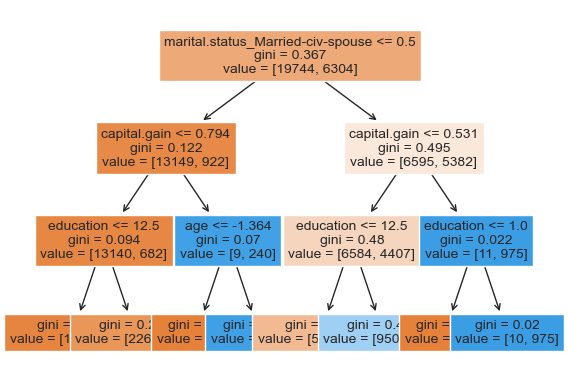

In [81]:
custom_plot_tree(pipe_dt.named_steps["decisiontreeclassifier"], feature_names = feature_names, fontsize=10)

Let's explore permutation importance. 
- For each feature this method evaluates the impact of permuting feature values 

In [82]:
from sklearn.inspection import permutation_importance
def get_permutation_importance(model):
    X_train_perm = X_train.drop(columns=["race", "education.num", "fnlwgt"])
    result = permutation_importance(model, X_train_perm, y_train_num, n_repeats=10, random_state=123)
    perm_sorted_idx = result.importances_mean.argsort()
    plt.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X_train_perm.columns[perm_sorted_idx],
    )
    plt.xlabel('Permutation feature importance')
    plt.show()

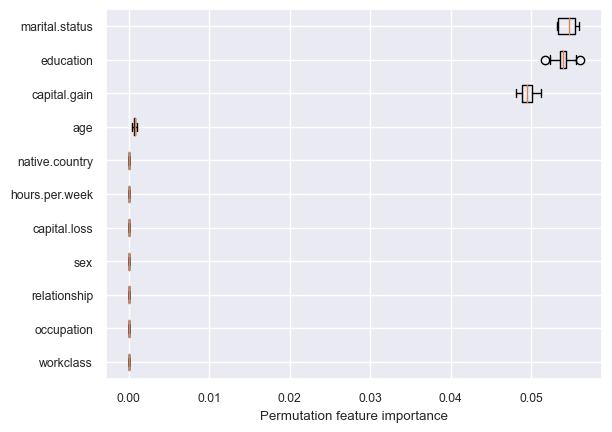

In [83]:
get_permutation_importance(pipe_dt)

Decision tree is primarily making all decisions based on three features: marital.status, education, and capital.gain. 

Let's create and fit a pipeline with preprocessor and random forest. 

#### Random forest feature importances

In [84]:
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=2))
pipe_rf.fit(X_train, y_train_num);

Which features are driving the predictions the most? 

In [85]:
data = {
    "Importance": pipe_rf.named_steps["randomforestclassifier"].feature_importances_,
}
rf_imp_df = pd.DataFrame(
    data=data,
    index=feature_names,
).sort_values(by="Importance", ascending=False)

In [86]:
rf_imp_df[:8]

,Importance
age,0.230412
education,0.122210
hours.per.week,0.114521
capital.gain,0.113815
marital.status_Married-civ-spouse,0.077887
relationship_Husband,0.044242
capital.loss,0.038287
marital.status_Never-married,0.025661


In [87]:
np.sum(pipe_rf.named_steps["randomforestclassifier"].feature_importances_)

0.9999999999999998

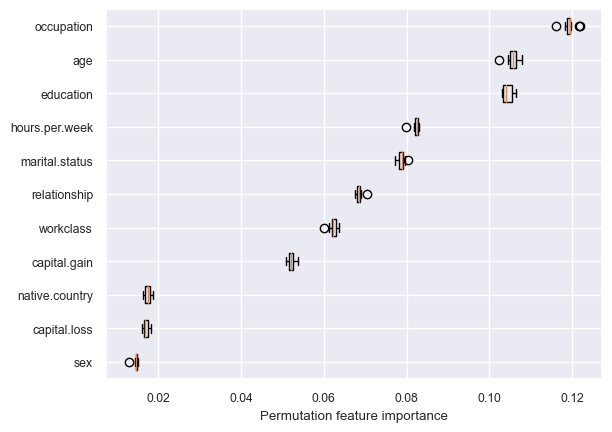

In [88]:
get_permutation_importance(pipe_rf)

Random forest is using more features in the model compared to decision trees. 

### Key point 

- Unlike the linear model coefficients, `feature_importances_` **do not have a sign**!
  - They tell us about importance, but not an "up or down".
  - Indeed, increasing a feature may cause the prediction to first go up, and then go down.
  - This cannot happen in linear models, because they are linear. 

### How can we get feature importances for non `sklearn` models? 

- One way to do it is by using a tool called [`eli5`](https://eli5.readthedocs.io/en/latest/overview.html).

Unfortunately, this is not compatible with the latest version of sklearn, which we are using. 

```
conda install -c conda-forge eli5
```

- Another popular way is using `SHAP`. You can install it using the following in the course conda environment. 

```conda install -c conda-forge shap```

<br><br><br><br>

## SHAP  (SHapley Additive exPlanations) introduction

### Explaining a prediction 

![](img/shap_example.png)
<!-- <img src="img/shap_example.png" width="600" height="600"> -->

[Source](https://github.com/slundberg/shap/blob/master/docs/presentations/February%202018%20Talk.pptx)

### SHAP  (SHapley Additive exPlanations)
- Based on the idea of shapely values. A shapely value is created for each example and each feature. 
- Can explain the prediction of an example by computing the contribution of each feature to the prediction. 
- Great visualizations 
- Support for different kinds of models; fast variants for tree-based models
- Original paper: [Lundberg and Lee, 2017](https://arxiv.org/pdf/1705.07874.pdf)

#### Our focus
- How to use it on our dataset?
- How to generate and interpret plots created by SHAP? 
- We are not going to discuss how SHAP works. 

![](img/shap_explanation2.png)
<!-- <img src="img/shap_explanation2.png" width="1000" height="1000"> -->

[Source](https://github.com/slundberg/shap/blob/master/docs/presentations/February%202018%20Talk.pptx)


- Start at a base rate (e.g., how often people get their loans rejected).
- Add one feature at a time and see how it impacts the decision. 

### SHAP on LGBM model 

- Let's try it out on our best performing LightGBM model. 
- You should have `shap` in the course conda environment

Let's create train and test dataframes with our transformed features. 

In [89]:
X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train).toarray(),
    columns=feature_names,
    index=X_train.index,
)
X_train_enc.head()

,age,capital.gain,capital.loss,hours.per.week,education,sex,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia,native.country_missing
5514,-0.921955,-0.147166,-0.21768,-1.258387,8.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
19777,-1.069150,-0.147166,-0.21768,-0.447517,8.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10781,-0.185975,-0.147166,-0.21768,-0.042081,13.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
32240,-1.216346,-0.147166,-0.21768,-1.663822,12.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9876,-0.553965,-0.147166,-0.21768,-0.042081,13.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [90]:
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test).toarray(),
    columns=feature_names,
    index=X_test.index,
)
X_test_enc.shape

(6513, 85)

Let's get SHAP values for train and test data. 

In [91]:
import shap

# Create a shap explainer object 
pipe_lgbm.named_steps["lgbmclassifier"].fit(X_train_enc, y_train)
lgbm_explainer = shap.TreeExplainer(pipe_lgbm.named_steps["lgbmclassifier"])
train_lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [92]:
train_lgbm_shap_values

[array([[ 4.08151507e-01,  2.82025568e-01,  4.70162085e-02, ...,
         -1.03017665e-03,  0.00000000e+00, -1.69027185e-03],
        [ 5.46019608e-01,  2.77536150e-01,  4.69698010e-02, ...,
         -9.00720988e-04,  0.00000000e+00, -6.78058051e-04],
        [-4.39095422e-01,  2.50475372e-01,  6.51137414e-02, ...,
         -9.02446630e-04,  0.00000000e+00, -3.54676006e-04],
        ...,
        [-1.05137470e+00,  1.89706451e-01, -2.74798624e+00, ...,
         -1.13229595e-03,  0.00000000e+00, -1.31449687e-04],
        [-6.32247597e-01,  3.01432486e-01,  8.99744241e-02, ...,
         -1.03411038e-03,  0.00000000e+00,  4.04709519e-04],
        [ 1.15559528e+00,  2.32397724e-01,  5.55862988e-02, ...,
         -1.05290827e-03,  0.00000000e+00, -8.11336331e-04]]),
 array([[-4.08151507e-01, -2.82025568e-01, -4.70162085e-02, ...,
          1.03017665e-03,  0.00000000e+00,  1.69027185e-03],
        [-5.46019608e-01, -2.77536150e-01, -4.69698010e-02, ...,
          9.00720988e-04,  0.00000000e

- For each example, each feature, and each class we have a SHAP value.
- SHAP values tell us how to fairly distribute the prediction among features. 
- For classification it's a bit confusing. It gives SHAP matrix for all classes.
- Let's stick to shap values for class 1, i.e., income > 50K. 

In [93]:
train_lgbm_shap_values[1].shape

(26048, 85)

In [94]:
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc)
test_lgbm_shap_values[1].shape

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


(6513, 85)

<br><br>

## SHAP plots

In [95]:
# load JS visualization code to notebook
shap.initjs()

### Force plots

- Most useful! 
- Let's try to explain predictions on a couple of examples from the test data. 
- I'm sampling some examples where target is <=50K and some examples where target is >50K. 

In [96]:
y_test_reset = y_test.reset_index(drop=True)
y_test_reset

0       <=50K
1       <=50K
2       <=50K
3       <=50K
4       <=50K
        ...  
6508    <=50K
6509    <=50K
6510     >50K
6511    <=50K
6512     >50K
Name: income, Length: 6513, dtype: object

In [97]:
l50k_ind = y_test_reset[y_test_reset == "<=50K"].index.tolist()
g50k_ind = y_test_reset[y_test_reset == ">50K"].index.tolist()

ex_l50k_index = l50k_ind[10]
ex_g50k_index = g50k_ind[10]

### Explaining a prediction

Imagine that you are given the following test example. 

In [98]:
X_test_enc.iloc[ex_l50k_index]

age                               0.476406
capital.gain                     -0.147166
capital.loss                      4.649658
hours.per.week                   -0.042081
education                         8.000000
                                    ...   
native.country_Trinadad&Tobago    0.000000
native.country_United-States      1.000000
native.country_Vietnam            0.000000
native.country_Yugoslavia         0.000000
native.country_missing            0.000000
Name: 345, Length: 85, dtype: float64

You get the following hard prediction, which you are interested in explaining.  

In [99]:
pipe_lgbm.named_steps["lgbmclassifier"].predict(X_test_enc)[ex_l50k_index]

'<=50K'

You can first look at `predict_proba` output to get a better understanding of model confidence. 

In [100]:
pipe_lgbm.named_steps["lgbmclassifier"].predict_proba(X_test_enc)[ex_l50k_index]

array([0.99240562, 0.00759438])

- The model seems quite confident. But if we want to know more, for example, which feature values are playing a role in this specific prediction, we can use SHAP force plots. 
- Remember that we have SHAP values per feature per example. We'll use these values to create SHAP force plot.  

In [101]:
pd.DataFrame(
    test_lgbm_shap_values[1][ex_l50k_index, :],
    index=feature_names,
    columns=["SHAP values"],
)

,SHAP values
age,0.723502
capital.gain,-0.253426
capital.loss,-0.256666
hours.per.week,-0.096692
education,-0.403715
...,...
native.country_Trinadad&Tobago,0.000000
native.country_United-States,0.003408
native.country_Vietnam,0.001051
native.country_Yugoslavia,0.000000


SHAP will produce the following type of plots.  

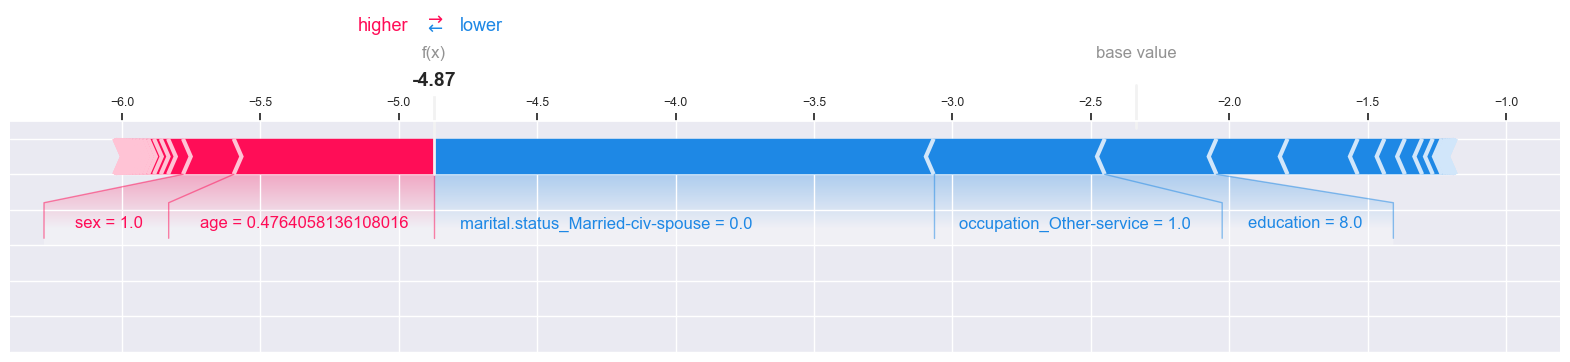

In [102]:
shap.force_plot(
    lgbm_explainer.expected_value[1], # expected value for class 1. 
    test_lgbm_shap_values[1][ex_l50k_index, :], # SHAP values associated with the example we want to explain
    X_test_enc.iloc[ex_l50k_index, :], # Feature vector of the example 
    matplotlib=True,
)

- The raw model score is much smaller than the base value, which is reflected in the prediction of <= 50k class. 
- sex = 1.0, scaled age = 0.48 are pushing the prediction towards higher score. 
- education = 8.0, occupation_Other-service = 1.0 and marital.status_Married-civ-spouse = 0.0 are pushing
the prediction towards lower score. 

In [103]:
pipe_lgbm.named_steps["lgbmclassifier"].classes_

array(['<=50K', '>50K'], dtype=object)

We can get the raw model output by passing `raw_score=True` in `predict`. 

In [104]:
pipe_lgbm.named_steps["lgbmclassifier"].predict(X_test_enc, raw_score=True)

array([-1.76270194, -7.61912405, -0.45555535, ...,  1.13521135,
       -6.62873917, -0.84062193])

What's the raw score of the example above we are trying to explain?  

In [105]:
pipe_lgbm.named_steps["lgbmclassifier"].predict(X_test_enc, raw_score=True)[ex_l50k_index]

-4.872722908439952

- The score matches with what we see in the force plot. 
- The base score above is the mean raw score. Our example has a lower raw score compared to the average raw score and the force plot tries to explain which feature values are bringing this score to a lower value. 

In [106]:
pipe_lgbm.named_steps["lgbmclassifier"].predict(X_train_enc, raw_score=True).mean()

-2.336411423367732

In [107]:
lgbm_explainer.expected_value[1]  # on average this is the raw score for class 1

-2.3364114233677307

Note: a nice thing about SHAP values is that the feature importances sum to the prediction:

In [108]:
test_lgbm_shap_values[1][ex_l50k_index, :].sum() + lgbm_explainer.expected_value[1]

-4.8727229084399575

<br><br>

Now let's try to explain another prediction. 
- The hard prediction here is 1. 
- From the `predict_proba` output it seems like the model is not too confident about the prediction. 

In [109]:
pipe_lgbm.named_steps["lgbmclassifier"].predict(X_test_enc)[ex_g50k_index]

'>50K'

In [110]:
# X_test_enc.iloc[ex_g50k_index]

In [111]:
pipe_lgbm.named_steps["lgbmclassifier"].predict_proba(X_test_enc)[ex_g50k_index]

array([0.35997929, 0.64002071])

What's the raw score for this example?

In [112]:
pipe_lgbm.named_steps["lgbmclassifier"].predict(X_test_enc, raw_score=True)[
    ex_g50k_index
]  # raw model score

0.5754540510801829

In [113]:
# pd.DataFrame(
#     test_lgbm_shap_values[1][ex_g50k_index, :],
#     index=feature_names,
#     columns=["SHAP values"],
# )

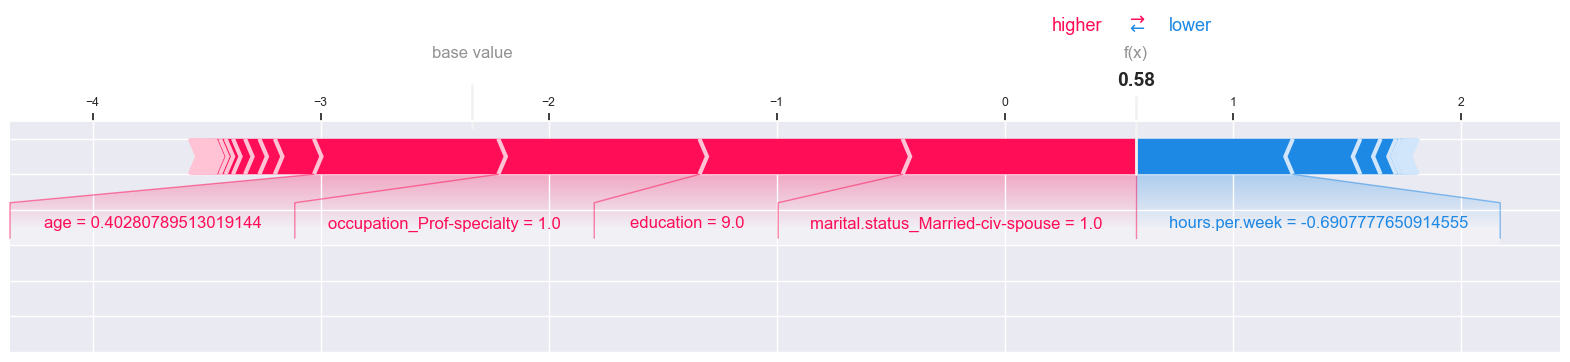

In [114]:
shap.force_plot(
    lgbm_explainer.expected_value[1],
    test_lgbm_shap_values[1][ex_g50k_index, :],
    X_test_enc.iloc[ex_g50k_index, :],
    matplotlib=True,
)

Observations: 

- Everything is with respect to class 1 here. 
- The base value, i.e., the average raw score for class 1 is -2.336. 
- We see the forces that drive the prediction. 
- That is, we can see the main factors pushing it from the base value (average over the dataset) to this particular prediction. 
- Features that push the prediction to a higher value are shown in red. 
- Features that push the prediction to a lower value are shown in blue.

<br><br>

### Global feature importance using SHAP

Let's look at the average SHAP values associated with each feature. 

In [115]:
values = np.abs(train_lgbm_shap_values[1]).mean(
    0
)  # mean of shapely values in each column
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[:10]

,SHAP
marital.status_Married-civ-spouse,1.074859
age,0.805468
capital.gain,0.565589
education,0.417642
hours.per.week,0.324636
sex,0.185687
capital.loss,0.148519
marital.status_Never-married,0.139914
relationship_Own-child,0.108003
occupation_Prof-specialty,0.106276


### Dependence plot

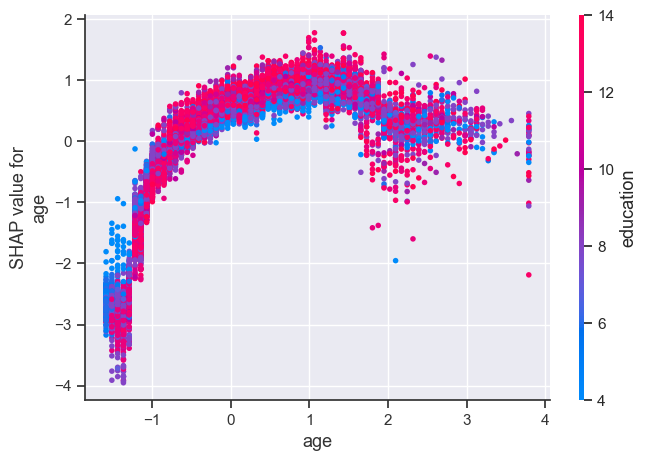

In [116]:
shap.dependence_plot("age", train_lgbm_shap_values[1], X_train_enc)

The plot above shows effect of `age` feature on the prediction. 

- Each dot is a single prediction for examples above.
- The x-axis represents values of the feature age (scaled).
- The y-axis is the SHAP value for that feature, which represents how much knowing that feature's value changes the output of the model for that example's prediction. 
- Lower values of age have smaller SHAP values for class ">50K".
- Similarly, higher values of age also have a bit smaller SHAP values for class ">50K", which makes sense.  
- There is some optimal value of age between scaled age of 1 which gives highest SHAP values for for class ">50K". 
- Ignore the colour for now. The color corresponds to a second feature (education feature in this case) that may have an interaction effect with the feature we are plotting. 

### Summary plot 

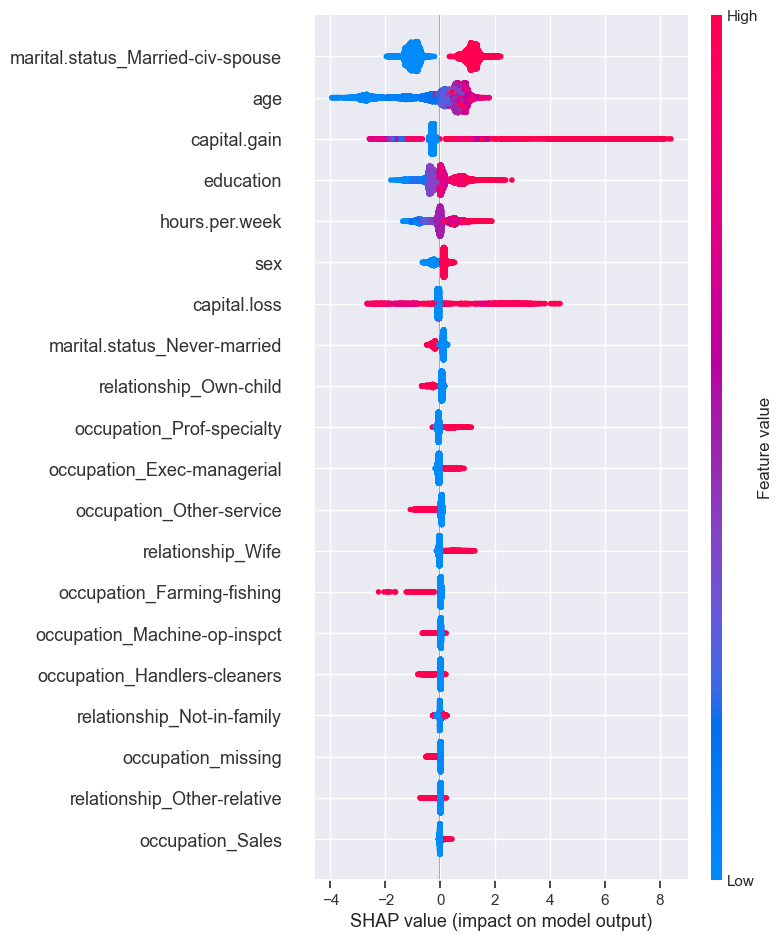

In [117]:
shap.summary_plot(train_lgbm_shap_values[1], X_train_enc)

The plot shows the most important features for predicting the class. It also shows the direction of how it's going to drive the prediction.  

- Presence of the marital status of Married-civ-spouse seems to have bigger SHAP values for class 1 and absence seems to have smaller SHAP values for class 1. 
- Higher levels of education seem to have bigger SHAP values for class 1 whereas smaller levels of education have smaller SHAP values. 

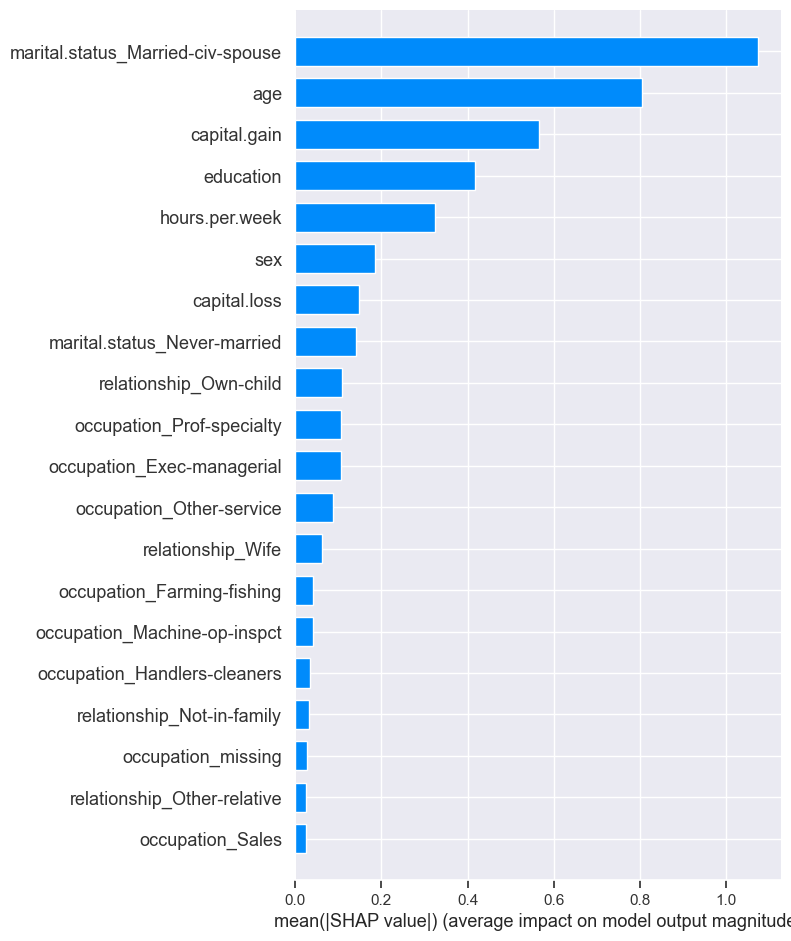

In [118]:
shap.summary_plot(train_lgbm_shap_values[1], X_train_enc, plot_type="bar")

You can think of this as global feature importances.

<br><br>

Here, we explore SHAP's TreeExplainer. It also provides explainer for different kinds of models. 

- [TreeExplainer](https://shap.readthedocs.io/en/latest/) (supports XGBoost, CatBoost, LightGBM) 
- [DeepExplainer](https://shap.readthedocs.io/en/latest/index.html#shap.DeepExplainer) (supports deep-learning models)
- [KernelExplainer](https://shap.readthedocs.io/en/latest/index.html#shap.KernelExplainer) (supports kernel-based models)
- [GradientExplainer](https://shap.readthedocs.io/en/latest/index.html#shap.GradientExplainer) (supports Keras and Tensorflow models)

- Can also be used to explain text classification and image classification 
- Example: In the picture below, red pixels represent positive SHAP values that increase the probability of the class, while blue pixels represent negative SHAP values the reduce the probability of the class. 

![](img/shap_image_explainer.png)
<!-- <img src="img/shap_image_explainer.png" width="600" height="600"> -->
    
[Source](https://github.com/slundberg/shap)

### Other tools

- [lime](https://github.com/marcotcr/lime) is another package.

If you're not already impressed, keep in mind:

- So far we've only used sklearn models.
- Most sklearn models have some built-in measure of feature importances.
- On many tasks we need to move beyond sklearn, e.g. LightGBM, deep learning.
- These tools work on other models as well, which makes them extremely useful.

#### Why do we want this information?

Possible reasons:

- Identify features that are not useful and maybe remove them.
- Get guidance on what new data to collect.
  - New features related to useful features -> better results.
  - Don't bother collecting useless features -> save resources.
- Help explain why the model is making certain predictions. 
  - Debugging, if the model is behaving strangely.
  - Regulatory requirements.
  - Fairness / bias. See [this](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/Explaining%20quantitative%20measures%20of%20fairness.html). 
  - Keep in mind this can be used on **deployment** predictions!

Here are some guidelines and important points to remember when you work on a prediction problem where you also want to understand which features are influencing the predictions.  

- Examine multicoliniarity in your dataset using methods such as VIF. 
- If you observe high correlations in your dataset, either get rid of redundant features or be mindful of these correlations during interpretation. 
- Be mindful that feature relevance is not clearly defined. Adding/removing features can change feature importance/unimportance. Also, feature importances do not give us causal relationships. See [this optional section](https://pages.github.ubc.ca/mds-2022-23/DSCI_573_feat-model-select_students/lectures/04_feat-importances-selection.html#optional-problems-with-feature-selection) from Lecture 4. 
- Most of the models we use in ML are regularized models. With L2 regularization, the feature importances are distributed evenly among correlated features. With L1 regularization, one of the correlated features gets a high importance and the other gets a lower importance.
- Don't be overconfident. Always take feature importance values with a grain of salt.  